# Mixup / Label smoothing

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_10 import *

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [39]:
fact_example= [math.factorial(i) for i in range(12)]

In [40]:
import functools

def fact(x):
    l = list(range(1, x + 1))
    return functools.reduce(lambda a,b : a*b, l)

[fact(i) for i in range(1, 10)]

[1, 2, 6, 24, 120, 720, 5040, 40320, 362880]

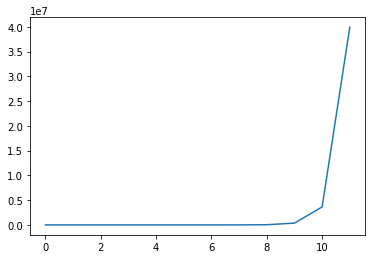

In [41]:
plt.plot(fact_example)

In [53]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
cat_processor = CategoryProcessor()
ll = label_by_func(sd, parent_labeler, proc_y=cat_processor)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

## Mixup

### What is mixup?

As the name kind of suggests, the authors of the [mixup article](https://arxiv.org/abs/1710.09412) propose to train the model on a mix of the pictures of the training set. Let's say we're on CIFAR10 for instance, then instead of feeding the model the raw images, we take two (which could be in the same class or not) and do a linear combination of them: in terms of tensor it's
``` python
new_image = t * image1 + (1-t) * image2
```
where t is a float between 0 and 1. Then the target we assign to that image is the same combination of the original targets:
``` python
new_target = t * target1 + (1-t) * target2
```
assuming your targets are one-hot encoded (which isn't the case in pytorch usually). And that's as simple as this.

In [64]:
img_idx1 = 0
img_idx2 = 4000

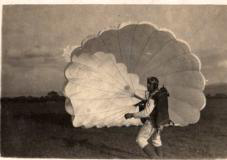

In [65]:
img1 = PIL.Image.open(ll.train.x.items[img_idx1])
img1

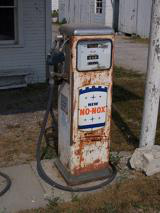

In [66]:
img2 = PIL.Image.open(ll.train.x.items[img_idx2])
img2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


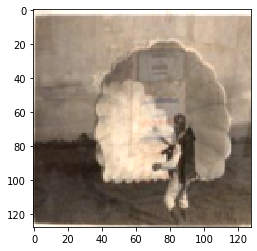

In [67]:
mixed_up = ll.train.x[img_idx1] + 0.3 * ll.train.x[img_idx2] * 0.7
plt.imshow(mixed_up.permute(1, 2, 0))

French horn or tench? The right answer is 70% french horn and 30% tench ;)

The implementation relies on something called the *beta distribution* which in turns uses something which Jeremy still finds mildly terrifying called the *gamma function*. To get over his fears, Jeremy reminds himself that *gamma* is just a factorial function that (kinda) interpolates nice and smoothly to non-integers too. How it does that exactly isn't important...

In [70]:
Γ = lambda x : x.lgamma().exp()

In [75]:
Γ(FloatTensor([1, 2, 3, 4, 5]))

tensor([ 1.,  1.,  2.,  6., 24.])

NB: If you see math symbols you don't know you can google them like this: [Γ function](https://www.google.com/search?q=Γ+function).

If you're not used to typing unicode symbols, on Mac type <kbd>ctrl</kbd>-<kbd>cmd</kbd>-<kbd>space</kbd> to bring up a searchable emoji box. On Linux you can use the [compose key](https://help.ubuntu.com/community/ComposeKey). On Windows you can also use a compose key, but you first need to install [WinCompose](https://github.com/samhocevar/wincompose). By default the <kbd>compose</kbd> key is the right-hand <kbd>Alt</kbd> key.

You can search for symbol names in WinCompose. The greek letters are generally <kbd>compose</kbd>-<kbd>\*</kbd>-<kbd>letter</kbd> (where *letter* is, for instance, <kbd>a</kbd> to get greek α alpha).

In [76]:
facts = [math.factorial(i) for i in range(7)]

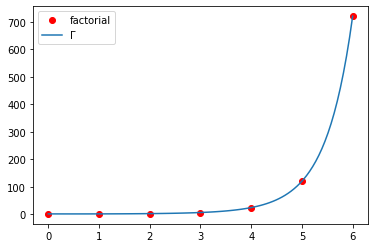

In [81]:
plt.plot(facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6) + 1))
plt.legend(['factorial', 'Γ'])

In [82]:
torch.linspace(0,0.9,10)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In the original article, the authors suggested three things:
 1. Create two separate dataloaders and draw a batch from each at every iteration to mix them up
 2. Draw a t value following a beta distribution with a parameter α (0.4 is suggested in their article)
 3. Mix up the two batches with the same value t.
 4. Use one-hot encoded targets

Why the beta distribution with the same parameters α? Well it looks like this:

In [ ]:
_, axs = plt.subplots(1, 2, figsize(12, 4))